<a href="https://colab.research.google.com/github/lamngue/College_Analysis/blob/main/Electing_College_in_the_United_States.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Background

College application are the ways for students to show their academics, extracurricular activities, soft skills, and perseverance for the school to which they apply. It is a daunting process until they are admitted, which includes deliberating on the choices and debating the pros and cons of going to each school. A factor that I am interested in predicting is the graduation rate, which shows the percentage of students in a particular college finishing their degree within 6-years. After some research, it is true that numerous factors influence graduation rates, including but not limited to the transfer-out rates or the types of school

This model will predict if Graduation Rate of a college is influenced by Type of School, Transfer out rates, Number of Undergraduate students and Net Price of attending that college.

# Importing the libraries

In [55]:
!pip install category_encoders

In [56]:
#Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

%matplotlib inline

# Importing the Dataset

The dataset was collected in 2013 (based on the Cohort Year column in the original dataset) and comes from the National Educational Statistics Center, which is filtered only by state, private-for-profit and non-profit institutions in the Midwest region (North and South Dakota, Nebraska, Kansas, Minnesota, Iowa, Missouri, Wisconsin, Illinois, Michigan, Indiana and Ohio). It was obtained from 504 private and public colleges across the U.S., consisting of 16 variables from its tuition and fee to whether the school is private.

In [57]:
college_data = pd.read_csv("https://raw.githubusercontent.com/lamngue/College_Analysis/main/__college_data.csv")
college_data = college_data.iloc[:, 1:]
college_data.columns = college_data.columns.str.replace(' ', '_')
college_data = college_data.rename(columns={'Transfer-Out_Rate': 'Transfer_Rate'})
college_data = college_data.rename(columns={'Net_Price_**' : 'Net_Price'})
college_data.head()

,Name,Type,Campus_setting,Student_population,Undergraduate_students,Graduation_Rate,Transfer_Rate,Net_Price
0,Adrian College,"4-year, Private not-for-profit",Town: Distant,1828.0,1779.0,50.0,4.0,24520.0
1,Albion College,"4-year, Private not-for-profit",Town: Fringe,1475.0,1475.0,70.0,24.0,18532.0
2,Allen College,"4-year, Private not-for-profit",City: Small,656.0,339.0,100.0,NaN,NaN
3,Alma College,"4-year, Private not-for-profit",Town: Distant,1442.0,1442.0,67.0,NaN,23180.0
4,Alverno College,"4-year, Private not-for-profit",City: Large,1744.0,1105.0,49.0,NaN,18384.0


#Exploratory Data Analysis

In [58]:
college_data.describe()

,Student_population,Undergraduate_students,Graduation_Rate,Transfer_Rate,Net_Price
count,484.000000,482.000000,458.000000,235.000000,456.000000
mean,5421.719008,4234.597510,55.126638,26.302128,19533.583333
std,8624.243620,6484.304862,19.412749,14.952567,6953.036175
min,16.000000,6.000000,0.000000,1.000000,2891.000000
25%,996.750000,770.000000,45.000000,17.000000,14936.000000
50%,2114.000000,1783.500000,56.000000,25.000000,19642.000000
75%,5820.000000,4434.250000,67.000000,33.000000,23366.500000
max,61391.000000,46818.000000,100.000000,100.000000,50167.000000


##Taking care of Missing Data

For this data set, we replace any missing values with the median of remaining values for every column.

In [59]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
imputer.fit(college_data.iloc[:, 4:])
college_data.iloc[:, 4:] = imputer.transform(college_data.iloc[:, 4:])
college_data.head()

,Name,Type,Campus_setting,Student_population,Undergraduate_students,Graduation_Rate,Transfer_Rate,Net_Price
0,Adrian College,"4-year, Private not-for-profit",Town: Distant,1828.0,1779.0,50.0,4.0,24520.0
1,Albion College,"4-year, Private not-for-profit",Town: Fringe,1475.0,1475.0,70.0,24.0,18532.0
2,Allen College,"4-year, Private not-for-profit",City: Small,656.0,339.0,100.0,25.0,19642.0
3,Alma College,"4-year, Private not-for-profit",Town: Distant,1442.0,1442.0,67.0,25.0,23180.0
4,Alverno College,"4-year, Private not-for-profit",City: Large,1744.0,1105.0,49.0,25.0,18384.0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Frequency')

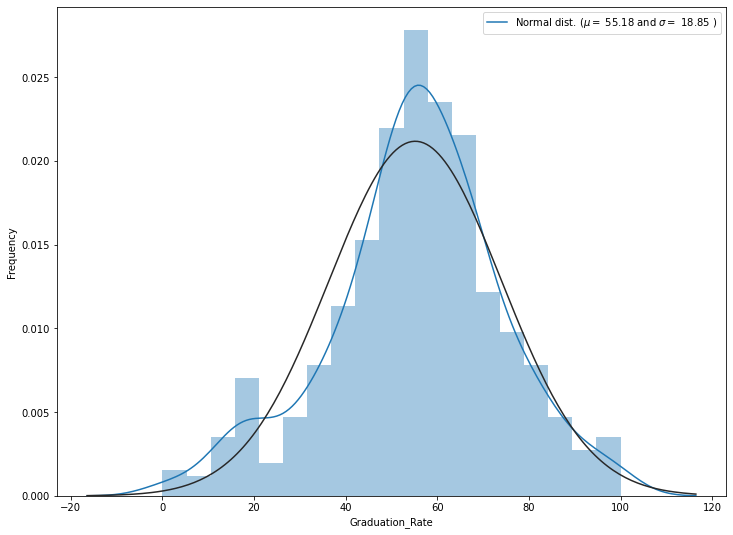

In [60]:
sns.set_style()
plt.subplots(figsize=(12,9))
disp = college_data['Graduation_Rate']
sns.distplot(disp, fit=stats.norm)
#get the mean and standard deviation
(mu, sigma) = stats.norm.fit(disp)
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')

The distribution of the graduation rate of universities and colleges in the Midwest in 2013 follows a normal distribution with at least one large outlier.  The mean rate is 55.18 percent, while the IQR for the rate is 24 percent.

#Encoding Categorical Data (Type)

Before fitting the model, we first encode the categorical variable in this dataset, which is Type (Type of the institution). The encoding is 0 for `4-year, Private not-for-profit`, 1 is for `4-year, Public`, 2 is for `4-year, primarily associate's, Public` and 3 is for `4-year, primarily associate's, Private not-for-profit`

In [61]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

mapping = {'4-year, Private not-for-profit':0,'4-year, Public':1,"4-year, primarily associate's, Public":2,"4-year, primarily associate's, Private not-for-profit":3}

college_data['Type'] = college_data['Type'].apply(lambda x : mapping[x])

college_data.head()

,Name,Type,Campus_setting,Student_population,Undergraduate_students,Graduation_Rate,Transfer_Rate,Net_Price
0,Adrian College,0,Town: Distant,1828.0,1779.0,50.0,4.0,24520.0
1,Albion College,0,Town: Fringe,1475.0,1475.0,70.0,24.0,18532.0
2,Allen College,0,City: Small,656.0,339.0,100.0,25.0,19642.0
3,Alma College,0,Town: Distant,1442.0,1442.0,67.0,25.0,23180.0
4,Alverno College,0,City: Large,1744.0,1105.0,49.0,25.0,18384.0


#Verify conditions before fitting the model

I found out that the distribution of data for residual vs. Undergraduate students' plot is not randomly scattered around the horizontal line, therefore, I decided to log transform the variable, which gives the appropriate distribution of data in that particular plot as shown below.

##Linearity and Uniform Spread

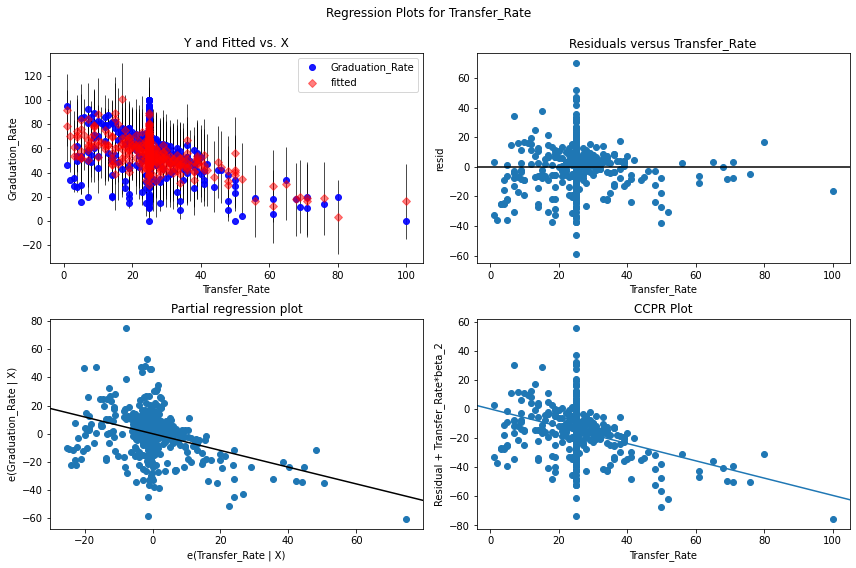

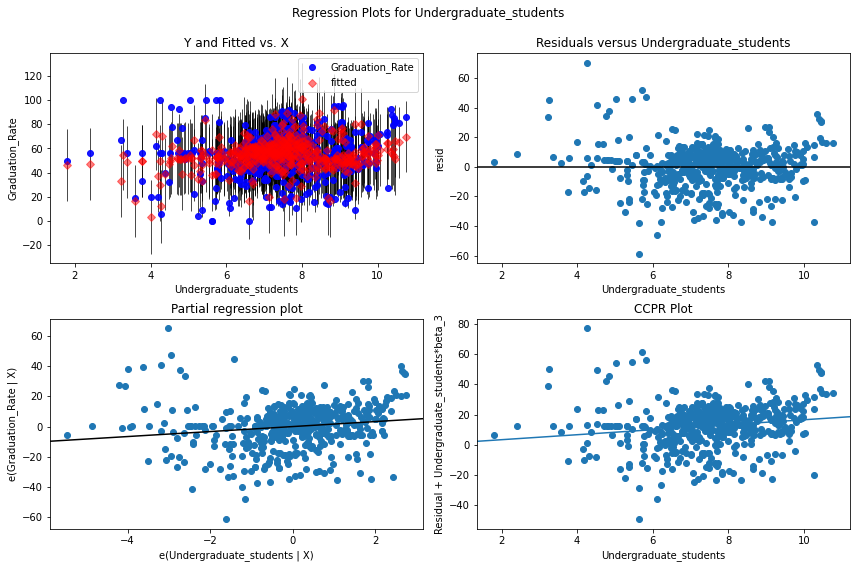

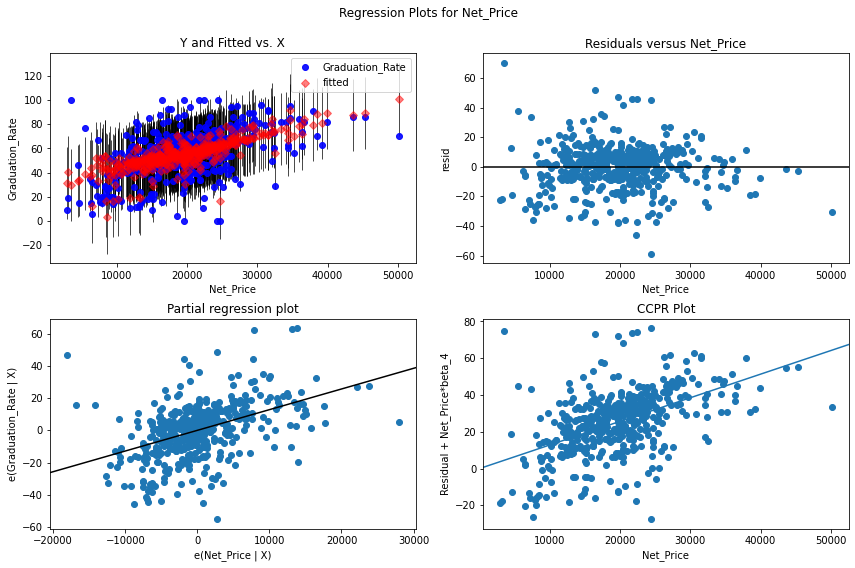

In [62]:
from numpy.ma.core import size
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

# log transfer Undergraduate students variable
to_log = ['Undergraduate_students']
college_data_log = college_data[to_log].applymap(lambda x: np.log(x))

# rename columns
college_data_log.columns = 'log_' + college_data_log.columns
college_data.iloc[:, 4] = college_data_log.iloc[:, 0]
#fit simple multilinear regression model
model = ols('Graduation_Rate ~ Type + Transfer_Rate + Undergraduate_students + Net_Price', data=college_data).fit()

#create residual vs. predictor plot for 'assists'
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'Transfer_Rate', fig=fig)

#create residual vs. predictor plot for 'assists'
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'Undergraduate_students', fig=fig)

#create residual vs. predictor plot for 'assists'
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'Net_Price', fig=fig)

Based on the plots, we are assured that the linearity and uniform spread requirements are not violated not because the data is not randomly scattered around the horizontal line.

##Normality

To assert normality, we plot the normal quantile plot of Residuals for the model, the result indicates that the majority of the points fall on the reference line, which satisfied this condition.

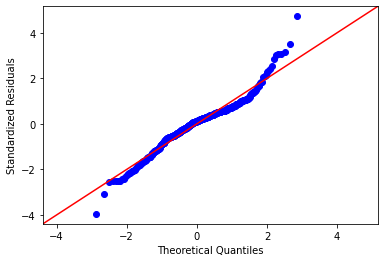

In [63]:
import statsmodels.api as sm
sm.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

##Randomness and Independence of Variables

About randomness, this condition would certainly be violated if I was trying to extend the results to all colleges in the U.S., which has more than 7000 institutions.  However, since my population of interest is colleges and universities in the Midwest, I do not believe this assumption is violated, it is reasonable to consider this a random sample. To check for the independence condition, based on what I know about the data collection process, there might be issues with lack of independence with schools data not collected overtime. However, since I'm only extended inference to institutions in the Midwest, I do not believe this assumption is violated.

##Conclusion

Since all five conditions are satisfied, we can affirm that the data is suitable to fit in a multiple linear regression model.

#Correlation

Text(0.5, 1.0, 'Correlation between variables')

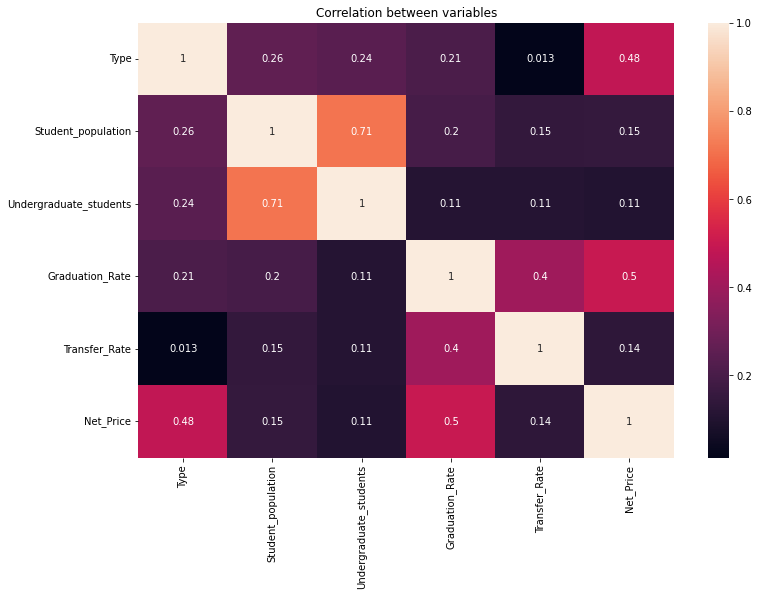

In [64]:
fig = plt.figure(figsize=(12,8))
sns.heatmap(college_data.corr().abs(), annot=True)
plt.title("Correlation between variables")

From the matrix, it can be seen that some potential explanatory variables appear to have a weak, positive, linear relationship with the response variable (Graduatin Rate) as is evident by the fact that the smallest correlation is 0.11. Further, the explanatory variables do not appear to be correlated with one another. All correlations between the explanatory variables are greater than 0.013 and smaller than 0.6. Therefore, we can conclude that there’s no multicollinearity in this model. 

#Model Analysis

The model we are interested in is represented as: $GraduationRate = \beta_0 + Type + log(UndergraduateStudents) + NetPrice + TransferRate$

In [65]:
#split the data into training and testing
y=college_data['Graduation_Rate']
X=college_data.drop(['Graduation_Rate', 'Student_population', 'Name', 'Campus_setting'],axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In this problem, we use a multilinear regression model.

In [66]:
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(X_train,y_train)

LinearRegression()

#Predicting Test Data

Text(0, 0.5, 'Predicted Y')

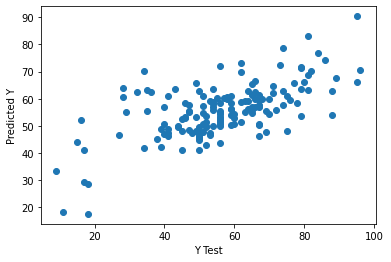

In [67]:
y_pred = mlr.predict(X_test)
#scatterplot real values vs predicted values
plt.scatter(y_test,y_pred)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

#Evaluating the model

In [68]:
# calculate the metrics
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Sqare root of Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('r_2 score:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 9.823217442616675
Mean Squared Error: 168.1643178103959
Sqare root of Mean Squared Error: 12.967818544782151
r_2 score: 0.4134613789008468


The $r^2$ value of 0.41 indicates that the changes in $GraduationRate$ can be partially explained by the changes of `Type`, `Undergraduate Students`, `Net Price` and `Transfer Rate`

##Conclusion

From the results of the fitted model above, it can be seen that the graduation rate in percentage of private and public schools in the Midwest is predicted by the type of school, the number of undergraduate students, the net price and the transfer-out rate.  This shows that transfer-out rate has an impact on predicting the graduation rate, while public or private schools do not matter. Another finding could be that the net price of school has a significant influence on graduation rates, which is in accordance to the belief that costs are one concerning factor when deciding where to go to college.

#Another way to make college decision

Since Type of School, Transfer out rates, Number of Undergraduate students and Net Price of attending that college is not entirely efficient in predicting the graduation rate of that college, we consider whether identifying some segments or clusters in college data will give us insights into which one predicts the highest graduation rate, and for that purpose, we use K-Means Clustering Algorithm.

Since Private Institutions - where number of students are smaller and are typically associated with higher costs, while Public Institutions are highly populated with students and are usually more affordable, it would be plausible to choose `Undergraduate_Students` and `Net_Price` as relevant patterns in the data.

In [69]:
college_data['Undergraduate_students'] = college_data[['Undergraduate_students']].applymap(lambda x: np.exp(x))
college_data.head()

,Name,Type,Campus_setting,Student_population,Undergraduate_students,Graduation_Rate,Transfer_Rate,Net_Price
0,Adrian College,0,Town: Distant,1828.0,1779.0,50.0,4.0,24520.0
1,Albion College,0,Town: Fringe,1475.0,1475.0,70.0,24.0,18532.0
2,Allen College,0,City: Small,656.0,339.0,100.0,25.0,19642.0
3,Alma College,0,Town: Distant,1442.0,1442.0,67.0,25.0,23180.0
4,Alverno College,0,City: Large,1744.0,1105.0,49.0,25.0,18384.0


##Using the elbow method to find the optimal number of clusters

Text(0, 0.5, 'WCSS')

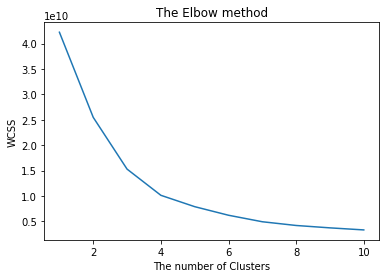

In [70]:
from sklearn.cluster import KMeans
wcss = []
X = college_data.iloc[:, [4, -1, 5]].values
for i in range(10):
  kmeans = KMeans(n_clusters=i+1, random_state=42, init='k-means++')
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow method')
plt.xlabel('The number of Clusters')
plt.ylabel('WCSS')

The result from the graph suggests that 3 would be an optimal number of clusters, which we will implement in the K-Means model training.

##Training the K-Means model on the dataset

In [71]:
kmeans = KMeans(n_clusters=3, random_state=42, init='k-means++')                   # Number of clusters == 3
kmeans = kmeans.fit(X)                          # Fitting the input data
labels = kmeans.predict(X)                      # Getting the cluster labels
centroids = kmeans.cluster_centers_    

## Visualising the clusters

Text(0.5, 0, 'Graduation Rate (percent)')

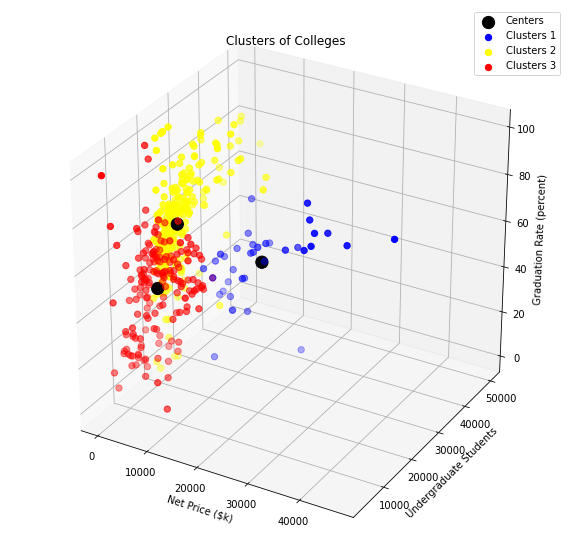

In [72]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

x = np.array(labels==0)
y = np.array(labels==1)
z = np.array(labels==2)


ax.scatter(centroids[:,0],centroids[:,1],centroids[:,2],c="black",s=150,label="Centers",alpha=1)
ax.scatter(X[x,0],X[x,1],X[x,2],c="blue",s=40,label="Clusters 1")
ax.scatter(X[y,0],X[y,1],X[y,2],c="yellow",s=40,label="Clusters 2")
ax.scatter(X[z,0],X[z,1],X[z,2],c="red",s=40,label="Clusters 3")
plt.title('Clusters of Colleges')
plt.xlabel('Net Price ($k)')
plt.legend()
plt.ylabel('Undergraduate Students ')
ax.set_zlabel("Graduation Rate (percent)")

The 3D plot illustrates that students in Institutions which are more affordable in Cluster 1 and 2 tend to graduate more within 6 years, regardless of the number of Undergraduate Students, which might imply that students in Public or Private Institutions perform equally. On the other hand, Institutions in Cluster 3 are generally more costly and students don't perform well academically, as shown by the highest graduation rate in 6 years of just over 40 percent. Overall, Institutions in Cluster 2 with low average Net Price and number of Undergraduate Students tend to have more students graduate in time. 

#Conclusion

The results from fitting a multilinear regression model could imply that the four main factors above (although there could be more) somewhat affect the graduation rate of undergraduate college students in the Midwest, while Clustering the data by number of `Undergraduate Students` and `Net Price` give a more insightful look into the how students in these Institutions perform. 

A potential confounding variable that is not included in the model would be the total number of students in an institution, which would include graduate students, research students or even exchange students. This could add up to the impact that the number of students have on the graduation rate. 

Although the study only targets institutions in the Midwest that have greater than 0 percent in graduation rate - 419 total in the dataset, which does not account for much of the total number of schools in the United States, I do not believe that the results could be generalized to all the institutions across the U.S. One explanation could be that the U.S is known for its diversity in education, however, schools in the Midwest are typically white-dominant, contrary to schools in less White states like California (Priceonomics, 2016). This could influence the graduation rate, such as Asians students are stereotyped to be hard-working and often overachieving, while Latinos students are often understood to be fallen behind White and Black (Kolodner, 2020). Therefore, racial makeup could be a potential confounding variable, although it is not included in the dataset. 

The study limits on only four explanatory variables, which is somewhat insufficient in predicting the outcome - graduation rate, which can be influenced by a few more variables such as racial makeup. Thus, the graduation rate predicted from this model could not be mostly accurate, as the addition of one variable can perhaps change the whole outcome of the prediction. However, the study could be helpful for high school students interested in pursuing a degree from an institution in the Midwest, as it covers both statistics from private and public institutions. 

In the future, to continue with this research, I would suggest exploring and implementing more variables that could be helpful in predicting the graduation rate. And if probable, doing research on community colleges could also be helpful for students interested. 


#References

Priceonomics. “Ranking the Most (and Least) Diverse Colleges in America.” Priceonomics, 2016. https://priceonomics.com/ranking-the-most-and-least-diverse-colleges-in/. 

Kolodner, Meredith. “Latino College Students Are Falling behind Whites and Blacks, New Research Shows.” The Hechinger Report, March 30, 2020. https://hechingerreport.org/latino-students-are-falling-behind-their-peers-in-college-new-research-shows/. 
